### Training Baseline Model

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

# 3-Layer CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(128 * 4 * 4, 10)  

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc(x)
        return x

model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99: 
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

torch.save(model.state_dict(), "model.pt")
print("Training complete! Model saved as 'model.pt'")

[1, 100] loss: 1.805
[1, 200] loss: 1.450
[1, 200] loss: 1.450
[1, 300] loss: 1.332
[1, 300] loss: 1.332
[2, 100] loss: 1.125
[2, 100] loss: 1.125
[2, 200] loss: 1.078
[2, 200] loss: 1.078
[2, 300] loss: 1.056
[2, 300] loss: 1.056
[3, 100] loss: 0.934
[3, 100] loss: 0.934
[3, 200] loss: 0.889
[3, 200] loss: 0.889
[3, 300] loss: 0.888
[3, 300] loss: 0.888
[4, 100] loss: 0.793
[4, 100] loss: 0.793
[4, 200] loss: 0.800
[4, 200] loss: 0.800
[4, 300] loss: 0.784
[4, 300] loss: 0.784
[5, 100] loss: 0.694
[5, 100] loss: 0.694
[5, 200] loss: 0.699
[5, 200] loss: 0.699
[5, 300] loss: 0.705
[5, 300] loss: 0.705
[6, 100] loss: 0.622
[6, 100] loss: 0.622
[6, 200] loss: 0.642
[6, 200] loss: 0.642
[6, 300] loss: 0.654
[6, 300] loss: 0.654
[7, 100] loss: 0.579
[7, 100] loss: 0.579
[7, 200] loss: 0.575
[7, 200] loss: 0.575
[7, 300] loss: 0.586
[7, 300] loss: 0.586
[8, 100] loss: 0.509
[8, 100] loss: 0.509
[8, 200] loss: 0.523
[8, 200] loss: 0.523
[8, 300] loss: 0.548
[8, 300] loss: 0.548
[9, 100] loss

### Per Channel Kmeans clustering to label each channel per activation type it fires on

In [60]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

layers_to_hook = ["conv1", "conv2", "conv3"]
activations = {}
def get_hook(name):
    def hook_fn(module, input, output):
        activations[name] = output.detach().cpu()
    return hook_fn

for name, module in model.named_modules():
    if name in layers_to_hook:
        module.register_forward_hook(get_hook(name))

transform = transforms.Compose([transforms.ToTensor()])
calib_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
calib_subset = Subset(calib_dataset, list(range(1500)))
calib_loader = DataLoader(calib_subset, batch_size=128, shuffle=False)

activation_bank = {name: [] for name in layers_to_hook}
images_list = []
with torch.no_grad():
    for x, _ in calib_loader:
        images_list.append(x.cpu())
        x = x.cuda()
        _ = model(x)
        for name in layers_to_hook:
            act = activations[name].cpu()
            act = act.mean(dim=(2,3))
            activation_bank[name].append(act)

for name in layers_to_hook:
    activation_bank[name] = torch.cat(activation_bank[name], dim=0)

images_tensor = torch.cat(images_list, dim=0)

def kmeans(x, num_clusters=4, num_iters=100):
    device = x.device
    N, D = x.shape
    centers = x[torch.randperm(N, device=device)[:num_clusters]]
    for _ in range(num_iters):
        dist = torch.cdist(x, centers)
        labels = dist.argmin(dim=1)
        new_centers = torch.zeros_like(centers)
        for k in range(num_clusters):
            pts = x[labels == k]
            if pts.shape[0] > 0:
                new_centers[k] = pts.mean(0)
            else:
                new_centers[k] = x[torch.randint(0, N, (1,), device=device)]
        centers = new_centers
    return centers, labels

cluster_centers = {}
cluster_labels = {}
for name in layers_to_hook:
    acts = activation_bank[name]
    acts_T = acts.T.cuda()
    num_clusters = acts_T.shape[0]
    c, l = kmeans(acts_T, num_clusters=num_clusters, num_iters=100)
    cluster_centers[name] = c.cpu()
    cluster_labels[name] = l.cpu()


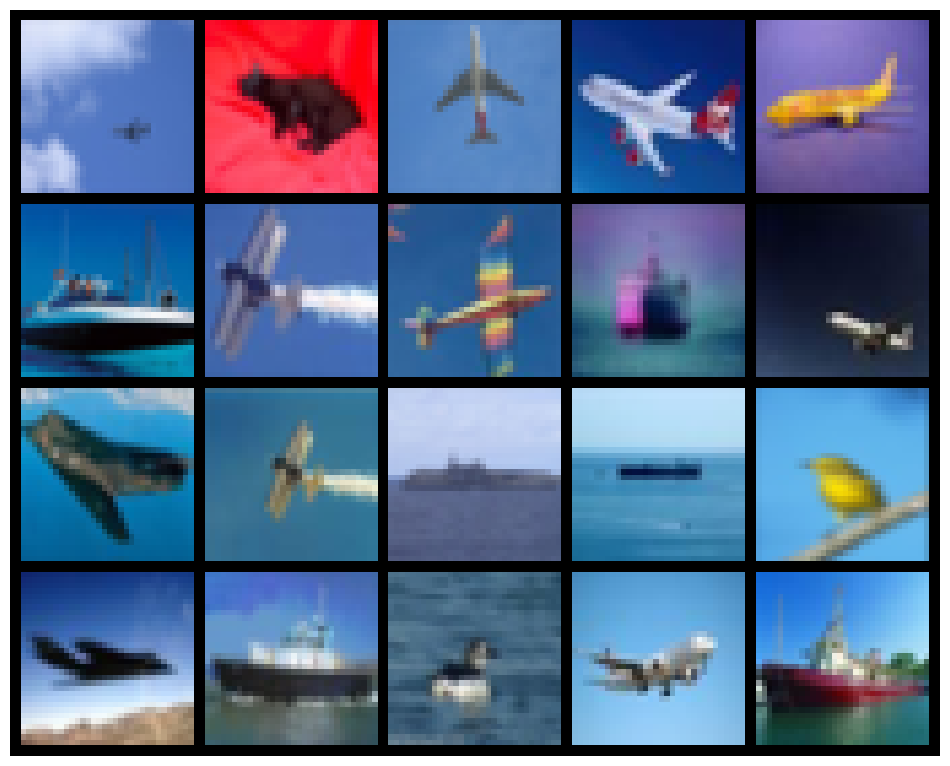

In [61]:
layer_name = "conv2"
cluster_idx = 9
max_images = 20

acts = activation_bank[layer_name]
channels_in_cluster = (cluster_labels[layer_name] == cluster_idx).nonzero(as_tuple=True)[0]
if channels_in_cluster.numel() == 0:
    scores = acts.mean(dim=1)
else:
    scores = acts[:, channels_in_cluster].mean(dim=1)
k = min(max_images, scores.shape[0])
top_idx = scores.topk(k).indices
selected_images = images_tensor[top_idx]

grid = make_grid(selected_images, nrow=5, normalize=True)
plt.figure(figsize=(12,12))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.show()

### L1 Sparsity Retraining

In [84]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 10


lambda_reg = 0.7 
epochs = 12
batch_size = 128
temp = 0.1

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

model = SimpleCNN()
model.load_state_dict(torch.load("model.pt", map_location=device))
model.to(device)
model.eval()
for p in model.parameters():
    p.requires_grad = False

print("model.pt loaded successfully!")

gate_logits = {}

for name in cluster_labels:
    num_clusters = int(cluster_labels[name].max().item()) + 1
    gate_logits[name] = torch.nn.Parameter(
        torch.ones(num_clusters, num_classes, device=device) * 0.5 
    )

current_masks = {}

def make_gating_hook(name):
    def hook(module, input, output):
        m = current_masks.get(name, None)
        if m is None: return None
        return output * m
    return hook

gating_handles = []
for name, module in model.named_modules():
    if name in cluster_labels:
        gating_handles.append(module.register_forward_hook(make_gating_hook(name)))

opt = torch.optim.Adam(gate_logits.values(), lr=0.05) 

print("Starting training...")
for epoch in range(epochs):
    total_ce = 0
    total_reg = 0
    steps = 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        bs = x.shape[0]
        current_masks.clear()
        reg = 0.0

        for name in cluster_labels:
            cl = cluster_labels[name].to(device)
            logits_per_channel = gate_logits[name][cl]    
            sel = logits_per_channel[:, y].T 
            probs = torch.sigmoid(sel / temp)            
            gate = probs.view(bs, -1, 1, 1)
            current_masks[name] = gate
            reg += probs.mean()

        out = model(x)
        loss_ce = F.cross_entropy(out, y)
        loss = loss_ce + lambda_reg * reg

        opt.zero_grad()
        loss.backward()
        opt.step()
        
        total_ce += loss_ce.item()
        total_reg += reg.item()
        steps += 1
    print(f"Epoch {epoch} | CE: {total_ce/steps:.4f} | Reg (avg gates open): {total_reg/steps:.4f}")


print("\n--- Active Counts ---")
for name in gate_logits:
    probs = torch.sigmoid(gate_logits[name].detach().cpu())
    active_per_class = (probs > 0.5).sum(dim=0) 
    print(f"{name} active clusters per class (first 10 classes):", active_per_class[:10].tolist())

for h in gating_handles:
    h.remove()

model.pt loaded successfully!
Starting training...
Epoch 0 | CE: 0.0857 | Reg (avg gates open): 0.9764
Epoch 0 | CE: 0.0857 | Reg (avg gates open): 0.9764
Epoch 1 | CE: 0.0632 | Reg (avg gates open): 0.5689
Epoch 1 | CE: 0.0632 | Reg (avg gates open): 0.5689
Epoch 2 | CE: 0.0636 | Reg (avg gates open): 0.4826
Epoch 2 | CE: 0.0636 | Reg (avg gates open): 0.4826
Epoch 3 | CE: 0.0717 | Reg (avg gates open): 0.4462
Epoch 3 | CE: 0.0717 | Reg (avg gates open): 0.4462
Epoch 4 | CE: 0.0754 | Reg (avg gates open): 0.4303
Epoch 4 | CE: 0.0754 | Reg (avg gates open): 0.4303
Epoch 5 | CE: 0.0751 | Reg (avg gates open): 0.4218
Epoch 5 | CE: 0.0751 | Reg (avg gates open): 0.4218
Epoch 6 | CE: 0.0740 | Reg (avg gates open): 0.4194
Epoch 6 | CE: 0.0740 | Reg (avg gates open): 0.4194
Epoch 7 | CE: 0.0731 | Reg (avg gates open): 0.4191
Epoch 7 | CE: 0.0731 | Reg (avg gates open): 0.4191
Epoch 8 | CE: 0.0713 | Reg (avg gates open): 0.4193
Epoch 8 | CE: 0.0713 | Reg (avg gates open): 0.4193
Epoch 9 | CE:

--- Analying Circuit for Image #120 ---
True Label: 2 (bird)

--- Circuit Definition (Active Channels) ---
Layer conv1: 3/32 channels active (9.4%)
   -> Active Indices: [14, 16, 21]
Layer conv2: 9/64 channels active (14.1%)
   -> Active Indices: [13, 14, 33, 41, 45, 49, 56, 61, 63]
Layer conv3: 21/128 channels active (16.4%)
   -> Active Indices: [0, 3, 10, 12, 20, 22, 23, 31, 42, 46, 52, 53, 59, 60, 65, 66, 83, 99, 101, 108, 127]

--- Verification Results ---
Original Model Prediction: bird (Conf: 0.3422)
Circuit Only Prediction:   bird (Conf: 0.9490)

SUCCESS: The sparse circuit successfully classified the image.


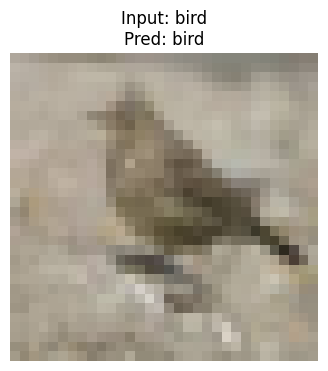

In [85]:
import matplotlib.pyplot as plt

img_idx = 120 
image_tensor, label_idx = train_dataset[img_idx]
input_batch = image_tensor.unsqueeze(0).to(device) 

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
target_class_name = class_names[label_idx]

print(f"--- Analying Circuit for Image #{img_idx} ---")
print(f"True Label: {label_idx} ({target_class_name})")


active_channels_map = {} 
total_params_original = 0
total_params_active = 0

print("\n--- Circuit Definition (Active Channels) ---")

for name in cluster_labels:
    logits_for_class = gate_logits[name][:, label_idx]
    probs = torch.sigmoid(logits_for_class)
    active_clusters = (probs > 0.5).nonzero(as_tuple=True)[0] 
    layer_cluster_map = cluster_labels[name].to(device)
    channel_mask = torch.isin(layer_cluster_map, active_clusters)
    active_channel_indices = channel_mask.nonzero(as_tuple=True)[0]
    active_channels_map[name] = active_channel_indices
    total_channels = len(layer_cluster_map)
    num_active = len(active_channel_indices)
    print(f"Layer {name}: {num_active}/{total_channels} channels active ({num_active/total_channels*100:.1f}%)")
    print(f"   -> Active Indices: {active_channel_indices.tolist()}")


def make_hard_mask_hook(active_indices):
    def hook(module, input, output):
        mask = torch.zeros_like(output)
        if len(active_indices) > 0:
            mask[:, active_indices, :, :] = 1.0
            
        return output * mask
    return hook

inference_handles = []
for name, module in model.named_modules():
    if name in active_channels_map:
        indices = active_channels_map[name]
        handle = module.register_forward_hook(make_hard_mask_hook(indices))
        inference_handles.append(handle)

with torch.no_grad():
    output_masked = model(input_batch)
    probs_masked = F.softmax(output_masked, dim=1)
    pred_masked = probs_masked.argmax(dim=1).item()
    confidence_masked = probs_masked[0, label_idx].item()
    for h in inference_handles:
        h.remove()

    output_full = model(input_batch)
    probs_full = F.softmax(output_full, dim=1)
    pred_full = probs_full.argmax(dim=1).item()
    confidence_full = probs_full[0, label_idx].item()

print("\n--- Verification Results ---")
print(f"Original Model Prediction: {class_names[pred_full]} (Conf: {confidence_full:.4f})")
print(f"Circuit Only Prediction:   {class_names[pred_masked]} (Conf: {confidence_masked:.4f})")

if pred_masked == label_idx:
    print("\nSUCCESS: The sparse circuit successfully classified the image.")
else:
    print("\nFAILURE: The circuit was too sparse and lost necessary features.")

plt.figure(figsize=(4,4))
plt.imshow(image_tensor.permute(1,2,0).cpu())
plt.title(f"Input: {target_class_name}\nPred: {class_names[pred_masked]}")
plt.axis('off')
plt.show()

### Unique Circuits

Visualizing Circuit Overlaps...


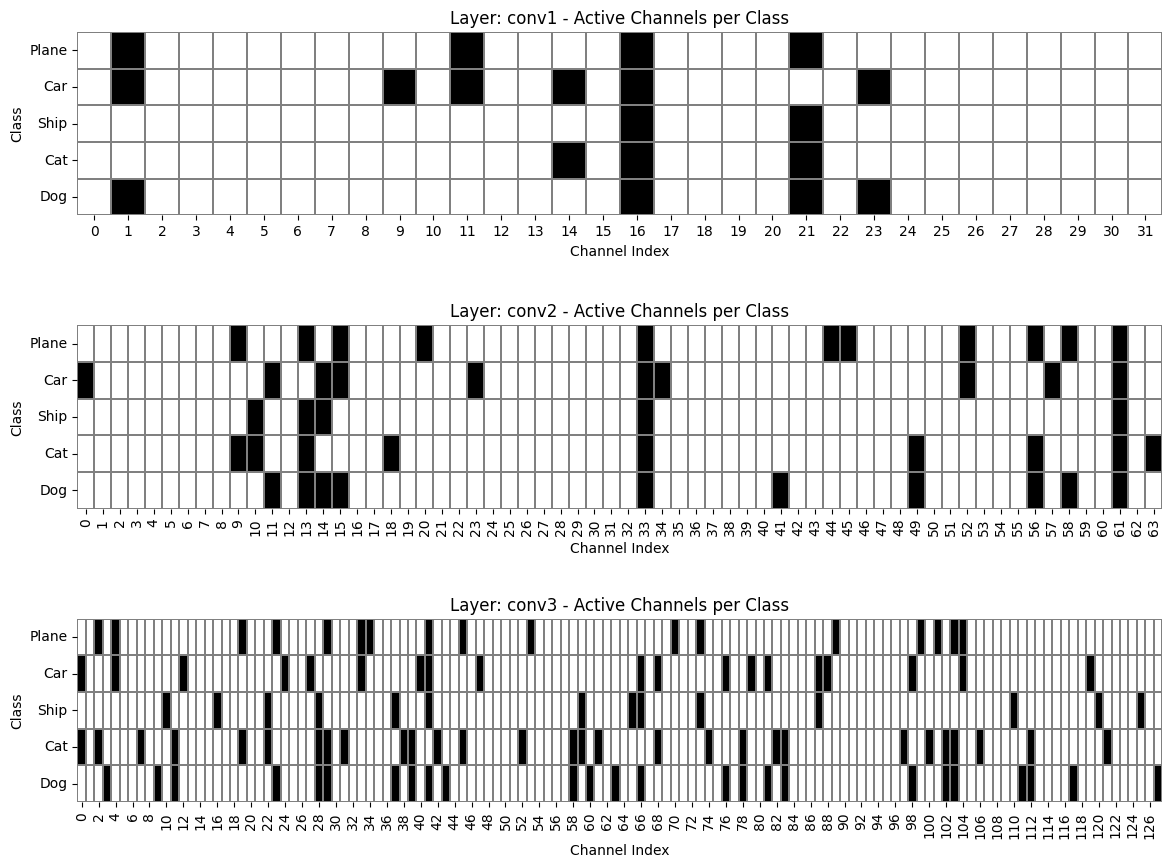


--- Pairwise Uniqueness (Jaccard Index / IoU) ---
Values closer to 1.0 mean classes share the same circuit.
Values closer to 0.0 mean classes use totally different channels.

[conv1]
   Plane vs Car  : IoU = 0.429
   Plane vs Ship : IoU = 0.500
   Plane vs Cat  : IoU = 0.400
   Plane vs Dog  : IoU = 0.600
   Car   vs Ship : IoU = 0.143
   Car   vs Cat  : IoU = 0.286
   Car   vs Dog  : IoU = 0.429
   Ship  vs Cat  : IoU = 0.667
   Ship  vs Dog  : IoU = 0.500
   Cat   vs Dog  : IoU = 0.400
   >> Core Features (Shared by ALL 5): 1 / 32 channels
      Indices: [np.int64(16)]
----------------------------------------
[conv2]
   Plane vs Car  : IoU = 0.235
   Plane vs Ship : IoU = 0.231
   Plane vs Cat  : IoU = 0.333
   Plane vs Dog  : IoU = 0.400
   Car   vs Ship : IoU = 0.250
   Car   vs Cat  : IoU = 0.118
   Car   vs Dog  : IoU = 0.333
   Ship  vs Cat  : IoU = 0.400
   Ship  vs Dog  : IoU = 0.364
   Cat   vs Dog  : IoU = 0.357
   >> Core Features (Shared by ALL 5): 2 / 64 channels
      I

In [87]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

target_classes = [0, 1, 8, 3, 5] 
full_class_names = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
selected_names = [full_class_names[i] for i in target_classes]

def get_active_mask(class_idx, layer_name):
    logits = gate_logits[layer_name][:, class_idx]
    probs = torch.sigmoid(logits)
    active_clusters = (probs > 0.5).nonzero(as_tuple=True)[0]
    layer_cluster_map = cluster_labels[layer_name].to(device)
    channel_mask = torch.isin(layer_cluster_map, active_clusters)
    return channel_mask.cpu().numpy()

fig, axes = plt.subplots(len(cluster_labels), 1, figsize=(14, 10))
plt.subplots_adjust(hspace=0.6)

circuit_data = {} 

for i, layer_name in enumerate(cluster_labels.keys()):
    masks = []
    if layer_name not in circuit_data: circuit_data[layer_name] = {}

    for idx, c in enumerate(target_classes):
        mask = get_active_mask(c, layer_name)
        masks.append(mask)
        circuit_data[layer_name][selected_names[idx]] = set(np.where(mask)[0])
    heatmap_data = np.array(masks).astype(int)
    ax = axes[i] if len(cluster_labels) > 1 else axes
    sns.heatmap(heatmap_data, ax=ax, cbar=False, cmap="Greys", linewidths=0.1, linecolor='gray')
    
    ax.set_title(f"Layer: {layer_name} - Active Channels per Class")
    ax.set_ylabel("Class")
    ax.set_xlabel("Channel Index")
    ax.set_yticks([x + 0.5 for x in range(len(target_classes))])
    ax.set_yticklabels(selected_names, rotation=0)

print("Visualizing Circuit Overlaps...")
plt.show()


print("\n--- Pairwise Uniqueness (Jaccard Index / IoU) ---")
print("Values closer to 1.0 mean classes share the same circuit.")
print("Values closer to 0.0 mean classes use totally different channels.\n")

for layer_name in cluster_labels.keys():
    print(f"[{layer_name}]")
    layer_sets = circuit_data[layer_name]
    class_keys = list(layer_sets.keys())
    for name_a, name_b in itertools.combinations(class_keys, 2):
        set_a = layer_sets[name_a]
        set_b = layer_sets[name_b]
        
        intersection = len(set_a.intersection(set_b))
        union = len(set_a.union(set_b))
        
        iou = intersection / union if union > 0 else 0.0
        note = ""
        if iou > 0.8: note = " (Highly Similar)"
        elif iou < 0.1: note = " (Distinct)"
            
        print(f"   {name_a:5s} vs {name_b:5s}: IoU = {iou:.3f}{note}")

    all_sets = list(layer_sets.values())
    common_core = set.intersection(*all_sets)
    total_channels = len(cluster_labels[layer_name])
    
    print(f"   >> Core Features (Shared by ALL 5): {len(common_core)} / {total_channels} channels")
    if len(common_core) > 0 and len(common_core) < 15:
        print(f"      Indices: {list(common_core)}")
    print("-" * 40)

Visualizing features for class: Truck


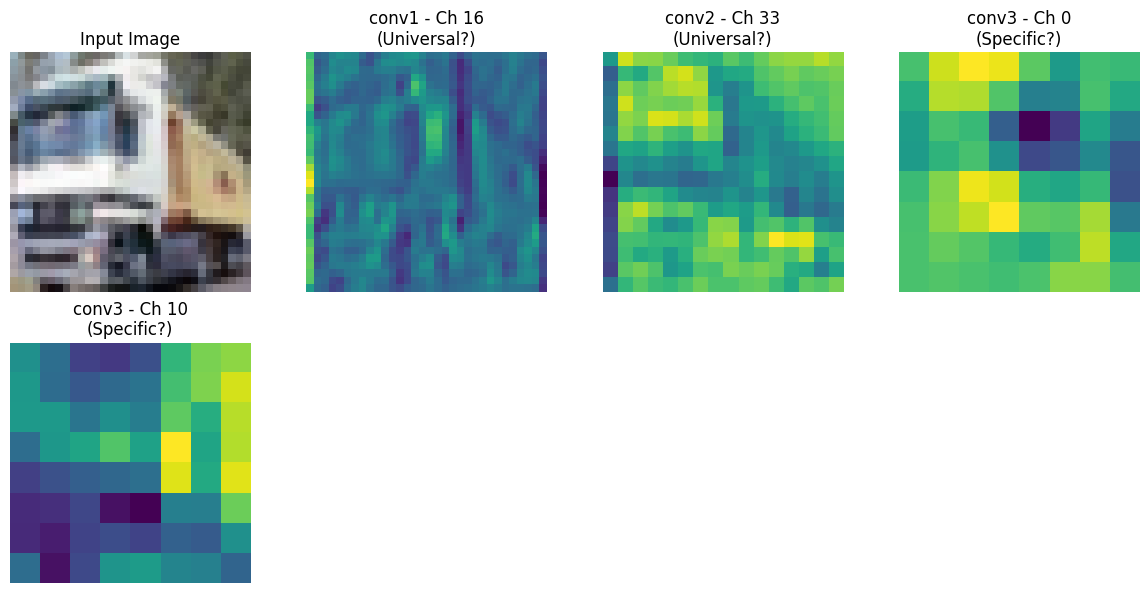

In [88]:
import matplotlib.pyplot as plt

img_idx = 1 
img_tensor, label = train_dataset[img_idx]
input_batch = img_tensor.unsqueeze(0).to(device)

print(f"Visualizing features for class: {full_class_names[label]}")

interesting_channels = {
    'conv1': [16],            
    'conv2': [33],           
    'conv3': [0, 10]      
}

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

handles = []
for name, module in model.named_modules():
    if name in interesting_channels:
        handles.append(module.register_forward_hook(get_activation(name)))

out = model(input_batch)

plt.figure(figsize=(12, 6))
img_np = img_tensor.permute(1, 2, 0).numpy()

plt.subplot(2, 4, 1)
plt.imshow(img_np)
plt.title("Input Image")
plt.axis('off')

plot_idx = 2
for layer_name, channel_indices in interesting_channels.items():
    act = activation[layer_name].cpu() 
    
    for ch_idx in channel_indices:
        if ch_idx < act.shape[1]: 
            plt.subplot(2, 4, plot_idx)
            fmap = act[0, ch_idx, :, :]
            
            plt.imshow(fmap, cmap='viridis')
            plt.title(f"{layer_name} - Ch {ch_idx}\n(Universal?)" if layer_name != 'conv3' else f"{layer_name} - Ch {ch_idx}\n(Specific?)")
            plt.axis('off')
            plot_idx += 1

for h in handles: h.remove()
plt.tight_layout()
plt.show()